In [1]:
import numpy as np

In [2]:
import matplotlib.gridspec as gridspec

In [3]:
import stained_glass.idealized as idealized
import stained_glass.stats as stats

## Make Explanatory Plot

## Parameters

In [4]:
# Number of sightlines
n = 10000
r_clump = 0.2

In [5]:
# Choose statistics
statistics = {
    'TPCF LS': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'ls' },
    },
    'TPCF simple': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'simple' },
    },
    'TPCF LS-radial': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'ls' },
        'radial': True,
    },
    'TPCF simple-radial': {
        'fn': stats.two_point_autocf,
        'fnkwargs': { 'estimator': 'simple' },
        'radial': True,
    },
}

#### Setup idealized projections

In [6]:
ips = []

In [7]:
# Radial distribution
ip = idealized.IdealizedProjection()
ip.add_ellipse(
    c = (0., 0.),
    a = 5.,
)
ips.append( ip )

In [8]:
# Radial distribution and satellite
ip = idealized.IdealizedProjection()
ip.add_ellipse(
    c = (0., 0.),
    a = 5.,
)
ip.add_ellipse(
    c = (6., 6.),
    a = 2.,
)
ips.append( ip )

In [9]:
# Clumps
ip = idealized.IdealizedProjection()
ip.add_clumps(
    r_clump = r_clump,
    c = (0., 0.),
    r_area = 5.,
    fcov = 0.5,
)
ips.append( ip )

In [10]:
# Filament
ip = idealized.IdealizedProjection()
ip.add_curve(
    v1 = (0., 0.),
    v2 = (-10., 2.),
    theta_a = 20.,
    theta_b = 60.,
)
ips.append( ip )

### Draw Plot

In [11]:
nrows = len( statistics ) + 2

In [12]:
ncols = len( ips )

/Users/zhafen/repos/stained_glass/stained_glass/stats.py:98: RuntimeWarning: divide by zero encountered in true_divide
  return ( n_dd - 2. * n_dr + n_rr ) / n_rr
/Users/zhafen/repos/stained_glass/stained_glass/stats.py:100: RuntimeWarning: divide by zero encountered in true_divide
  return n_dd / n_rr - 1.
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
/Users/zhafen/repos/stained_glass/stained_glass/stats.py:98: RuntimeWarning: invalid value encountered in true_divide
  return ( n_dd - 2. * n_dr + n_rr ) / n_rr
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
/Users/zhafen/repos/stained_glass/stained_glass/stats.py:100: RuntimeWarning: invalid value encountered in true_divide
  return n_dd / n_rr - 1.
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:10

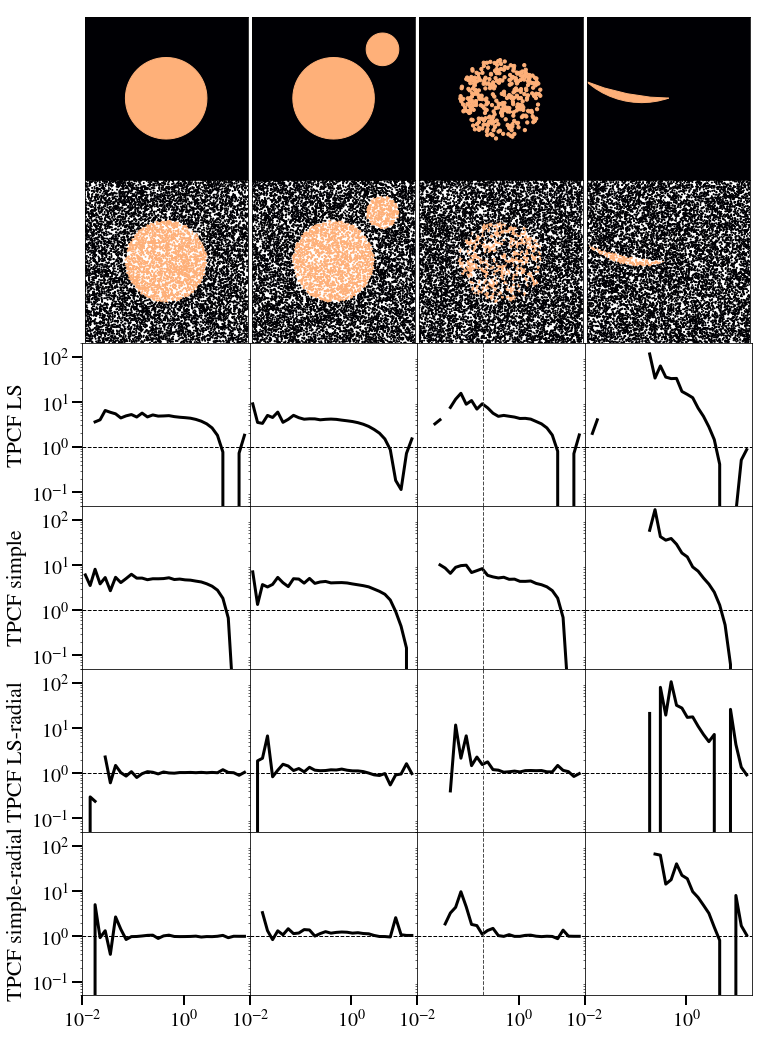

In [13]:
fig = plt.figure( figsize=(3*ncols, 3*nrows), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec( nrows, ncols )
gs.update( wspace=0.0001, hspace=0.0001 )

for i, ip in enumerate( ips ):
    
    ip.add_background( 0 )
    
    # Generate sightlines
    ip.generate_sightlines( n )
    
    # Plot the idealized image
    ax = plt.subplot( gs[0,i], )
    ip.plot_idealized_projection(
        ax,
    )
    
    # Plot the sightlines
    ax = plt.subplot( gs[1,i], )
    ip.plot_sightlines(
        ax,
        s = int( 10000 / n),
    )
    
    # Get sightlines for statistics
    coords = np.array([ ip.sl_xs, ip.sl_ys ]).transpose()
    vs = ip.evaluate_sightlines()
    is_detected = np.isclose( vs, 1 )
    coords_det = coords[is_detected]
    
    # Calculate the statistics
    for j, ( key, item ) in enumerate( statistics.items() ):
        
        ax = plt.subplot( gs[2+j,i], )
        
        # Calculate statistic
        edges = np.logspace( -2., np.log10( 20. ), 32 )
        stat, edges = item['fn'](
            coords_det,
            bins = edges,
            maxes = np.array([ ip.x_max, ip.y_max ]),
            mins = np.array([ ip.x_min, ip.y_min ]),
            **item['fnkwargs']
        )
        
        # A version that attempts to cancel out radial trends
        # by dividing the correlation function for the same data spread randomly at the
        # same radius
        if 'radial' in list( item.keys() ):
            rs = np.linalg.norm( coords_det, axis=1 )
            
            r_hist, r_edges = np.histogram(
                rs,
                bins = np.linspace( 0., np.sqrt(2.) * 10., 32 ),
            )
            r_randoms = []
            for m, n_annulus in enumerate( r_hist ):
                r_randoms.append(
                    stats.generate_randoms_in_annulus(
                        n_annulus,
                        r_edges[m],
                        r_edges[m+1],
                    )
                )
            r_randoms = np.concatenate( r_randoms )
            r_stat, edges = item['fn'](
                r_randoms,
                bins = edges,
                maxes = np.array([ ip.x_max, ip.y_max ]),
                mins = np.array([ ip.x_min, ip.y_min ]),
                **item['fnkwargs']
            )
            
            stat = stat / r_stat - 1.
        
        # Plot result
        xs = edges[:-1] + 0.5 * ( edges[1] - edges[0] )
        ax.plot(
            xs,
            1. + stat,
            linewidth = 3,
            color = 'k',
        )
        
        ax.axhline(
            1.,
            linewidth = 1.,
            color = 'k',
            linestyle = '--',
        )
        
        if i == 2:
            ax.axvline(
                r_clump,
                linewidth = 1.,
                color = '.3',
                linestyle = '--',
            )
        
# Go back through and fix up axes
for i in range( ncols ):
    for j in range( nrows ):
        
        ax = plt.subplot( gs[j,i], )
        
        # Projection Plot options
        if j < 2:
            
            ax.set_aspect( 'equal' )
            ax.tick_params( labelleft=False, labelbottom=False, left=False, bottom=False)
            
        # Statistics options
        if j > 1:
            
            # Remove tick labels
            if not ax.is_first_col():
                ax.tick_params( labelleft=False, left=False, )
            if not ax.is_last_row():
                ax.tick_params( labelbottom=False, bottom=False )
            
            # Limits for statistics
            ax.set_xlim( edges[0], edges[-1] )
            ax.set_ylim( 0.05, 200 )
            
            ax.set_xscale( 'log' )
            ax.set_yscale( 'log' )
            
            if ax.is_first_col():
                ax.set_ylabel( list( statistics.keys() )[j-2], fontsize=22 )

In [14]:
import unyt

In [15]:
dx = ( 600 * unyt.kpc ) / 1024

In [16]:
dx

unyt_quantity(0.5859375, 'kpc')

In [23]:
l = ( ( 7000 * unyt.msun ) / ( 1e-1 * unyt.mp * unyt.cm**-3) )**(1./3.)

In [24]:
l.to( 'kpc' )

unyt_quantity(0.1414563, 'kpc')